In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Unzip data model and test set

In [0]:
!unzip ./drive/My\ Drive/Colab\ Notebooks/BTL/model.zip
!unzip ./drive/My\ Drive/Colab\ Notebooks/BTL/test.zip

## Import libraries

In [0]:
import cv2
import numpy as np
import os
from keras.models import model_from_json
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
import time

from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


## Load model and define necessary functions

In [0]:
def true_positives_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def predict(UNet, path):
    img = image.load_img(path, target_size=(864, 1536))
    ori_img = image.img_to_array(img)
    img = preprocess_input(ori_img)
    img = np.expand_dims(img, axis=0)
    ret = (UNet.predict(img)[0] > 0.5).astype(np.float32)

    return ori_img, ret

best_UNet = load_model('./best_unet_v2.hdf5', custom_objects={'dice_coef': dice_coef,'true_positives_rate': true_positives_rate})

json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/model.h5")

W0724 20:31:24.800313 140517543655296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 20:31:24.860438 140517543655296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 20:31:24.900163 140517543655296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0724 20:31:25.737748 140517543655296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0724 20:31:25.739365 140517543655296 deprecation_

### Show U-net and CNNs model

In [0]:
best_UNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 864, 1536, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 864, 1536, 64 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 864, 1536, 64 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 432, 768, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [0]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 48, 32)        2432      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 11, 11, 64)        256       
_________________________________________________________________
flatten_7 (Flatten)          (None, 7744)              0         
__________

## Define function perform end to end
**Args:** 
* input_path: is the path of image that want to locate ID card.
* output_path: is the path where store ID card

In [0]:
def Predict_system(input_path, output_path):
#   original = cv2.imread(input_path)
#   original = cv2.resize(original, (1536,864))
  
  original, img = predict(best_UNet, input_path)
  img = np.reshape(img, (864, 1536))
  

  kernel = np.ones((15, 15), np.uint8)
  opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
  blur = cv2.GaussianBlur(opening, (15, 15), 0)
  blur = np.reshape(blur, (864, 1536, 1))
  blur = np.concatenate((blur, blur, blur), axis=2)

  gray = cv2.cvtColor(blur , cv2.COLOR_RGB2GRAY)
  gray = np.uint8(gray)


  _, cnts, _ = cv2.findContours(image=gray, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

  # Find contours with maximum area
  maxArea = 0
  maxContour = None
  for c in cnts:
    if (cv2.contourArea(c) > maxArea) and (cv2.contourArea(c) >= 500):
        maxArea = cv2.contourArea(c)
        maxContour = c

  #   cv2.fillPoly(img, [maxContour], (255, 255, 255))

  epsilon = 0.05 * cv2.arcLength(maxContour, True)

  approx = cv2.approxPolyDP(maxContour, epsilon, True)
  img = cv2.drawContours(img, [approx], -1, (0, 255, 0), 5)

  if approx.shape[0] == 4:
    approx = np.reshape(approx, (4, 2))
    approx_inv = np.zeros_like(approx)
    approx_inv[0] = approx[3]
    approx_inv[1] = approx[2]
    approx_inv[2] = approx[1]
    approx_inv[3] = approx[0]
    approx = approx_inv

    pts1 = np.float32(approx)
    pts2 = np.float32([[0., 0], [476, 0], [476, 476], [0, 476]])

    M = cv2.getPerspectiveTransform(np.float32(pts1), np.float32(pts2))
    dst = cv2.warpPerspective(original, M, (476, 476))
    result = dst

    dst_copy = cv2.resize(dst, (52, 52))
    dst_copy = np.reshape(dst_copy, (1, 52, 52, 3))
    dst_copy = dst_copy/255.
    predict_label = loaded_model.predict(dst_copy)
    label_pred = np.argmax(predict_label)

    M1 = cv2.getRotationMatrix2D((476/2, 476/2), 90, 1)
    M2 = cv2.getRotationMatrix2D((476/2, 476/2), 180, 1)
    M3 = cv2.getRotationMatrix2D((476/2, 476/2), -90, 1)

    if label_pred == 1:
        result = cv2.warpAffine(dst, M3, (476, 476))
    elif label_pred == 2:
        result = cv2.warpAffine(dst, M2, (476, 476))
    elif label_pred == 3:
        result = cv2.warpAffine(dst, M1, (476, 476))
    result = cv2.resize(result, (476, 300))
    dst = cv2.resize(dst, (476, 300))

    if os.path.isdir(output_path) == False:
      os.mkdir(path=output_path)
    else:
  #     cv2.imwrite(os.path.join(output_path, 'ret_' + os.path.basename(input_path)), result)
      image.save_img(os.path.join(output_path, 'ret_' + os.path.basename(input_path)), result)

## Load about 20 images to test effect of our model

In [0]:
path_batch_img = '/content'
path_save_result = './result'
start_batch = time.time()
for name_img in os.listdir(path_batch_img):
  if (name_img[-3:] == 'jpg') or (name_img[-3:] == 'png'):
    Predict_system(input_path=os.path.join(path_batch_img, name_img), output_path=path_save_result)
end_batch = time.time()
print("Total time used: " + str(end_batch - start_batch))

Total time used: 57.88839292526245


In [0]:
len(os.listdir('./'))

60

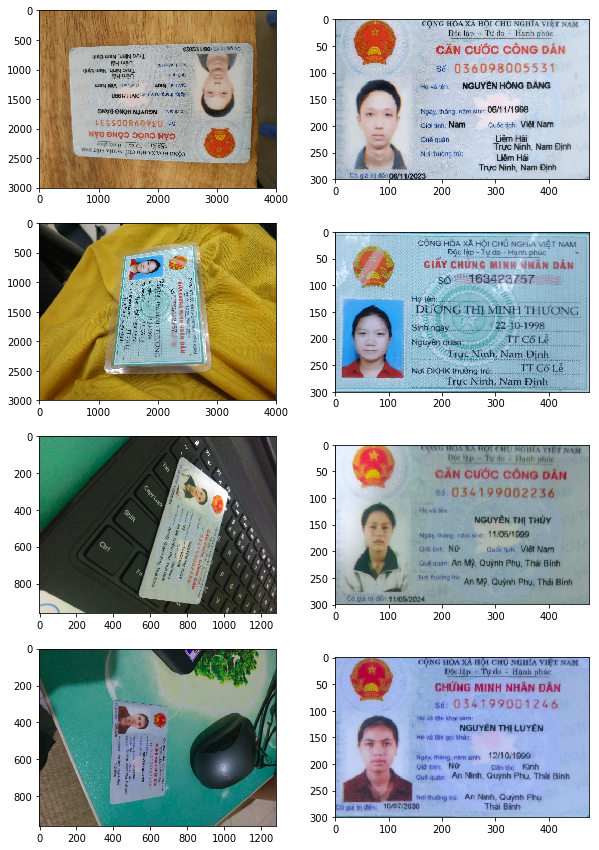

In [0]:
import matplotlib.pyplot as plt
img1 = plt.imread('./IMG_20190724_110537.jpg')
img1_res = plt.imread('./result/ret_IMG_20190724_110537.jpg')

img2 = plt.imread('./IMG_20190724_162651.jpg')
img2_res = plt.imread('/content/result/ret_IMG_20190724_162651.jpg')

img3 = plt.imread('/content/img_226.png')
img3_res = plt.imread('./result/ret_img_226.png')

img4 = plt.imread('/content/img_302.png')
img4_res = plt.imread('/content/result/ret_img_302.png')
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(10, 15))
ax[0][0].imshow(img1)
ax[0][1].imshow(img1_res)
ax[1][0].imshow(img2)
ax[1][1].imshow(img2_res)
ax[2][0].imshow(img3)
ax[2][1].imshow(img3_res)
ax[3][0].imshow(img4)
ax[3][1].imshow(img4_res)

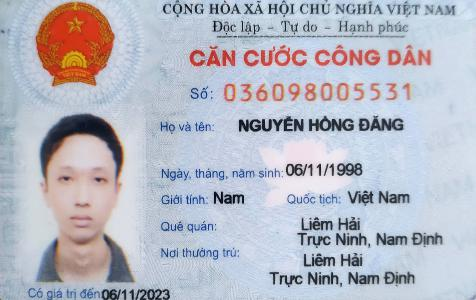

In [0]:
from IPython.display import Image
Image('/content/result/ret_IMG_20190724_110537.jpg')